### Nama: Richie Rich Kennedy Zakaria ###
Cohort ID: MC271D05Y2626

### INSTALL SASTRAWI

Akurasi pelabelan otomatis: 33.01%


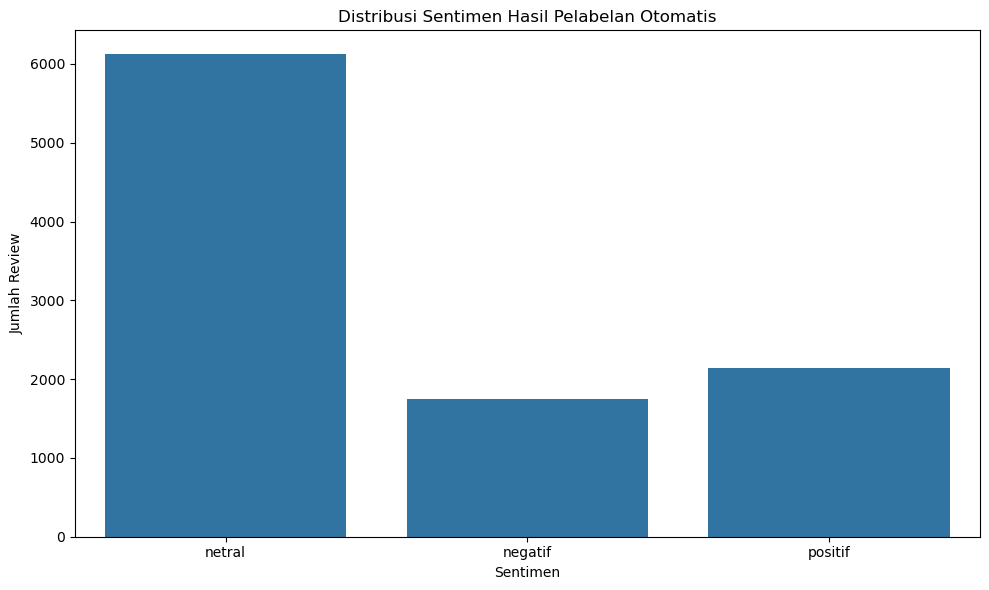


Confusion Matrix (Rating vs Predicted Sentiment):
Predicted Sentiment  negatif  netral  positif
Rating                                       
1                        796    2295      225
2                        176     504       65
3                        198     601      119
4                        149     431      201
5                        423    2290     1527


In [6]:
import pandas as pd
import re
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Buat stemmer dan stopword remover
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_factory = StopWordRemoverFactory()
stopword = stop_factory.create_stop_word_remover()

# Function untuk preprocessing text
def preprocess_text(text):
    # Handling NaN
    if isinstance(text, float) and np.isnan(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    text = stopword.remove(text)
    
    # Stemming
    text = stemmer.stem(text)
    
    return text

# Lexicon yang lebih lengkap
lexicon_positif = [
    "bagus", "keren", "puas", "suka", "mantap", "joss", "rekomendasi",
    "enak", "senang", "bahagia", "responsif", "cepat", "lancar", "stabil",
    "menyenangkan", "kece", "gampang", "mudah", "wow", "luar biasa",
    "nyaman", "canggih", "terima kasih", "asik", "membantu", "terbaik", "optimal",
    "memuaskan", "ramah", "efisien", "handal", "praktis", "ampuh",
    "bermanfaat", "tak ada duanya", "great", "perfect", "top", "ok",
    "not bad", "positif", "meningkat", "andalan"
]

lexicon_negatif = [
    "bug", "lag", "jelek", "lambat", "buruk", "lemot", "error", "crash",
    "mahal", "parah", "kecewa", "berat", "boros", "malas", "curang", "penipuan",
    "menyebalkan", "susah", "ribet", "rumit", "tidak stabil", "sering hang",
    "kurang", "ga mau", "tidak bisa", "bermasalah", "mengganggu", "bingung",
    "mengecewakan", "sampah", "gagal", "minta refund", "delete", "hapus",
    "jangan download", "rugi", "bohong", "tipu", "sia-sia", "buang-buang",
    "merugikan", "bikin emosi", "ga jelas", "aneh", "negatif", "memburuk"
]

lexicon_netral = [
    "biasa", "lumayan", "standar", "oke lah", "masih ok", "terserah",
    "boleh juga", "mungkin", "kadang", "tidak tahu", "ga tau", "fifty-fifty",
    "tidak buruk tapi tidak bagus", "tengah", "begitulah", "meh"
]

# Function untuk mendeteksi negasi
def contains_negation(text):
    negation_words = ["tidak", "bukan", "belum", "jangan", "tak", "ga", "gak", "nggak", "ndak"]
    return any(word in text.split() for word in negation_words)

# Function untuk pelabelan sentimen dengan bobot dan konteks
def label_sentiment_weighted(text):
    preprocessed_text = preprocess_text(text)
    words = preprocessed_text.split()
    
    # Hitung skor
    pos_score = 0
    neg_score = 0
    
    # Deteksi negasi
    has_negation = contains_negation(preprocessed_text)
    
    # Hitung kemunculan kata dalam lexicon
    for word in words:
        if word in lexicon_positif:
            pos_score += 1
        elif word in lexicon_negatif:
            neg_score += 1
    
    # Jika ada negasi, bisa membalikkan sentimen
    if has_negation:
        # Jika ada kalimat negatif dengan kata positif, kemungkinan negatif
        if pos_score > 0:
            neg_score += pos_score * 0.8
            pos_score *= 0.2
        # Jika ada kalimat negatif dengan kata negatif, bisa jadi positif atau netral
        elif neg_score > 0:
            pos_score += neg_score * 0.5
            neg_score *= 0.5
    
    # Skor final
    if pos_score > neg_score and pos_score > 0:
        return "positif"
    elif neg_score > pos_score and neg_score > 0:
        return "negatif"
    else:
        return "netral"

# Contoh penggunaan
# Asumsikan df adalah DataFrame yang berisi review
df = pd.read_csv('cod_mobile_reviews_10k.csv')  # Sesuaikan dengan nama file Anda

# Tambahkan kolom baru dengan hasil preprocessing
df['clean_review'] = df['content'].apply(preprocess_text)

# Tambahkan kolom label sentimen
df['sentiment_label'] = df['content'].apply(label_sentiment_weighted)

# Validasi hasil dengan skor review sebagai perbandingan
def validate_with_score(row):
    score = row['score']
    sentiment = row['sentiment_label']
    
    # Definisi acuan: skor 1-2 = negatif, 3 = netral, 4-5 = positif
    if score <= 2:
        expected = "negatif"
    elif score == 3:
        expected = "netral"
    else:  # score >= 4
        expected = "positif"
    
    return expected == sentiment

# Tambahkan kolom validasi
df['is_valid'] = df.apply(validate_with_score, axis=1)

# Hitung akurasi sederhana
accuracy = df['is_valid'].mean()
print(f"Akurasi pelabelan otomatis: {accuracy:.2%}")

# Visualisasi distribusi sentimen
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df)
plt.title('Distribusi Sentimen Hasil Pelabelan Otomatis')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

# Konfusi antara skor dan label sentimen
confusion = pd.crosstab(
    df['score'], 
    df['sentiment_label'], 
    rownames=['Rating'], 
    colnames=['Predicted Sentiment']
)
print("\nConfusion Matrix (Rating vs Predicted Sentiment):")
print(confusion)

Dimensi TF-IDF features: (10000, 4443)

Top keywords for positif sentiment:
  - bagus: 0.1698
  - mantap: 0.0657
  - keren: 0.0656
  - game: 0.0592
  - nya: 0.0464
  - sangat: 0.0345
  - game nya: 0.0337
  - nya bagus: 0.0298
  - suka: 0.0297
  - sangat bagus: 0.0295

Top keywords for netral sentiment:
  - game: 0.0424
  - nya: 0.0233
  - login: 0.0224
  - update: 0.0209
  - seru: 0.0187
  - main: 0.0170
  - gak: 0.0168
  - good: 0.0155
  - ga: 0.0152
  - baik: 0.0146

Top keywords for negatif sentiment:
  - game: 0.0444
  - bug: 0.0432
  - nya: 0.0377
  - main: 0.0282
  - banyak: 0.0262
  - update: 0.0253
  - bagus: 0.0232
  - susah: 0.0222
  - login: 0.0221
  - makin: 0.0220


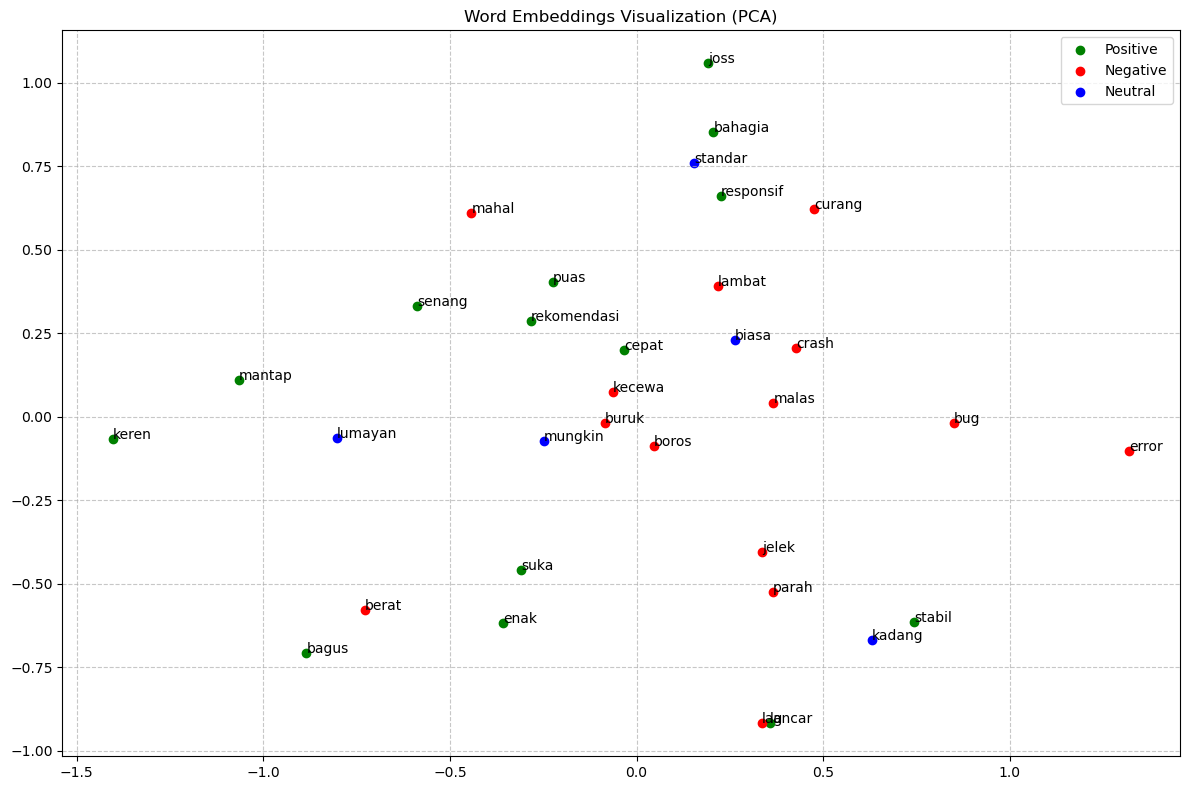

Data dengan fitur dan label telah disimpan ke 'cod_reviews_labeled.csv'


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. TF-IDF Feature Extraction
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)
)

# Fit dan transform korpus
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_review'])

# Tampilkan dimensi fitur
print(f"Dimensi TF-IDF features: {tfidf_features.shape}")

# 2. Ekstrak kata penting per kategori sentimen
def extract_top_features_per_class(vectorizer, tfidf_features, labels, top_n=10):
    # Untuk masing-masing kelas sentimen
    feature_names = vectorizer.get_feature_names_out()
    
    # Ubah ke format array
    tfidf_dense = tfidf_features.toarray()
    
    result = {}
    for sentiment in set(labels):
        # Filter untuk kelas ini
        indices = [i for i, label in enumerate(labels) if label == sentiment]
        
        if not indices:
            continue
            
        # Ambil rata-rata TF-IDF untuk kelas ini
        class_tfidf = np.mean(tfidf_dense[indices], axis=0)
        
        # Ambil top N fitur
        top_indices = class_tfidf.argsort()[-top_n:][::-1]
        top_features = [(feature_names[i], class_tfidf[i]) for i in top_indices]
        
        result[sentiment] = top_features
    
    return result

# Ekstrak kata kunci untuk setiap sentimen
top_features = extract_top_features_per_class(
    tfidf_vectorizer, 
    tfidf_features, 
    df['sentiment_label'].tolist()
)

# Tampilkan kata kunci per sentimen
for sentiment, features in top_features.items():
    print(f"\nTop keywords for {sentiment} sentiment:")
    for feature, score in features:
        print(f"  - {feature}: {score:.4f}")

# 3. Word Embeddings dengan Word2Vec (opsional)
# Tokenisasi untuk Word2Vec
tokenized_sentences = df['clean_review'].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # Skip-gram
    workers=4
)

# Function untuk mengambil vektor kata dari Word2Vec
def get_word_vector(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return None

# Visualisasi beberapa kata dari lexicon menggunakan PCA
def visualize_word_embeddings(model, positive_words, negative_words, neutral_words):
    words = []
    vectors = []
    categories = []
    
    # Proses kata positif
    for word in positive_words[:15]:  # Ambil 15 kata pertama saja
        vector = get_word_vector(word, model)
        if vector is not None:
            words.append(word)
            vectors.append(vector)
            categories.append('Positive')
    
    # Proses kata negatif
    for word in negative_words[:15]:
        vector = get_word_vector(word, model)
        if vector is not None:
            words.append(word)
            vectors.append(vector)
            categories.append('Negative')
    
    # Proses kata netral
    for word in neutral_words[:10]:
        vector = get_word_vector(word, model)
        if vector is not None:
            words.append(word)
            vectors.append(vector)
            categories.append('Neutral')
    
    if not vectors:
        print("Tidak ada vektor kata yang ditemukan dalam model")
        return
    
    # Reduksi dimensi dengan PCA
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)
    
    # Visualisasi
    plt.figure(figsize=(12, 8))
    
    # Pisahkan berdasarkan kategori
    for category in ['Positive', 'Negative', 'Neutral']:
        indices = [i for i, cat in enumerate(categories) if cat == category]
        color = 'green' if category == 'Positive' else 'red' if category == 'Negative' else 'blue'
        plt.scatter(
            [result[i, 0] for i in indices],
            [result[i, 1] for i in indices],
            label=category,
            color=color
        )
        
        # Tambahkan label kata
        for i in indices:
            plt.annotate(words[i], (result[i, 0], result[i, 1]))
    
    plt.title('Word Embeddings Visualization (PCA)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualisasi word embeddings jika model berhasil dilatih
try:
    visualize_word_embeddings(word2vec_model, lexicon_positif, lexicon_negatif, lexicon_netral)
except Exception as e:
    print(f"Tidak bisa visualisasi embeddings: {e}")

# 4. Simpan DataFrame setelah ekstraksi fitur dan pelabelan
df.to_csv('cod_reviews_labeled.csv', index=False)
print("Data dengan fitur dan label telah disimpan ke 'cod_reviews_labeled.csv'")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Classes: ['negatif' 'netral' 'positif'], Total: 3
Training data shape: (8000,)
Testing data shape: (2000,)
Found 9021 unique tokens
X_train_pad shape: torch.Size([8000, 100])
X_test_pad shape: torch.Size([2000, 100])
TextCNN(
  (embedding): Embedding(10001, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Starting training...
Epoch 1/15, Train Loss: 0.7301, Train Acc: 0.7111, Val Loss: 0.5373, Val Acc: 0.8087
Epoch 2/15, Train Loss: 0.5172, Train Acc: 0.8013, Val Loss: 0.4489, Val Acc: 0.8250
Epoch 3/15, Train Loss: 0.4146, Train Acc: 0.8496, Val Loss: 0.4036, Val Acc: 0.8550
Epoch 4/15, Train Loss: 0.3548, Train Acc: 0.8703, Val Loss: 0.3650, Val Acc: 0.8650
Epoch 5/15, Train Loss: 0.2978, Train Acc: 0.8886, Val L

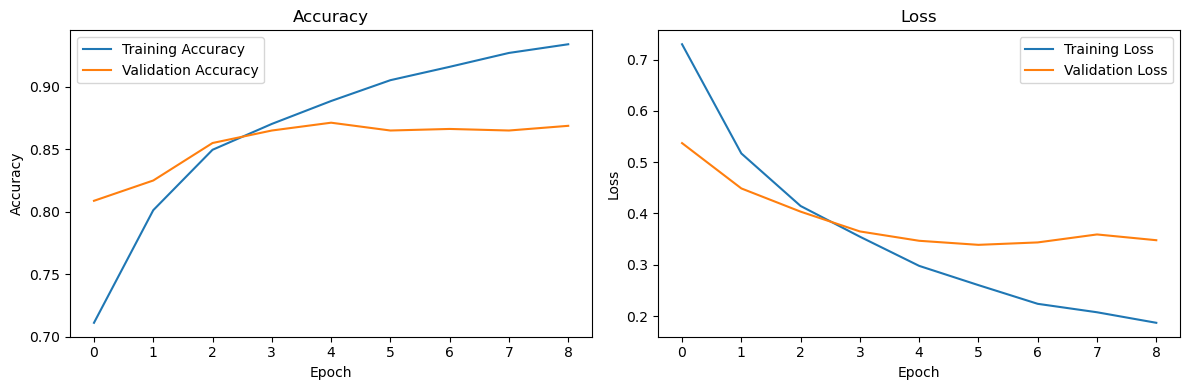

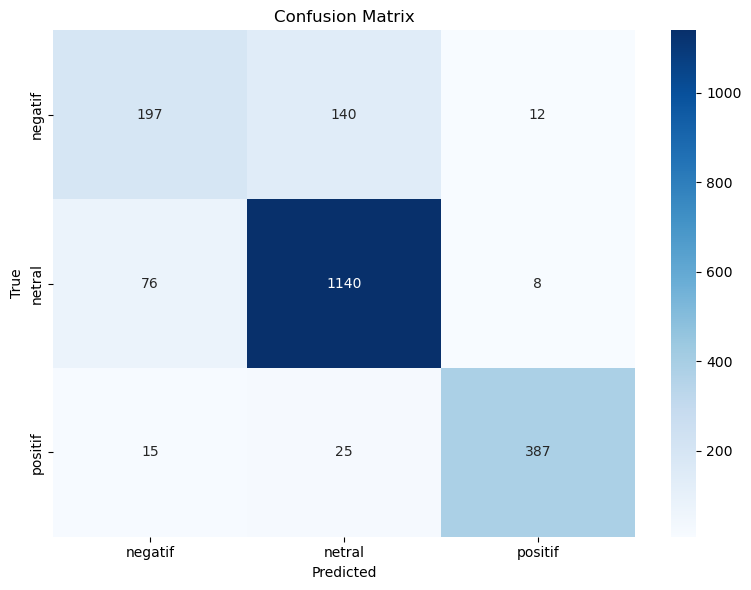

Model and preprocessing objects saved successfully!


In [8]:
%pip install scikit-learn pandas numpy matplotlib seaborn
%pip install torch torchvision
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Define the Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# 2. Define the CNN model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(TextCNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Conv layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, 
                      out_channels=num_filters, 
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        
    def forward(self, text):
        # text shape: [batch size, seq len]
        
        # embedded: [batch size, seq len, embedding dim]
        embedded = self.embedding(text)
        
        # embedded: [batch size, embedding dim, seq len]
        embedded = embedded.permute(0, 2, 1)
        
        # Apply convolution and max-pooling
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        
        # Apply max pooling
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        
        # Concatenate the output of different filter sizes
        cat = torch.cat(pooled, dim=1)
        
        # Apply dropout
        dropped = self.dropout(cat)
        
        # Final linear layer
        return self.fc(dropped)

# 3. Tokenization and preprocessing functions
class SimpleTokenizer:
    def __init__(self, max_words=10000):
        self.max_words = max_words
        self.word_index = {}
        self.word_counts = {}
        
    def fit_on_texts(self, texts):
        # Count all words
        for text in texts:
            for word in text.split():
                if word not in self.word_counts:
                    self.word_counts[word] = 0
                self.word_counts[word] += 1
        
        # Sort words by frequency
        sorted_words = sorted(self.word_counts.items(), 
                              key=lambda x: x[1], 
                              reverse=True)[:self.max_words-1]
        
        # Create word index (0 is reserved for padding)
        self.word_index = {word: i+1 for i, (word, _) in enumerate(sorted_words)}
        
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            seq = [self.word_index.get(word, 0) for word in text.split()]
            sequences.append(seq)
        return sequences

def pad_sequences(sequences, maxlen):
    padded_seqs = []
    for seq in sequences:
        if len(seq) > maxlen:
            padded_seqs.append(seq[:maxlen])  # Truncate
        else:
            padded_seqs.append(seq + [0] * (maxlen - len(seq)))  # Pad
    return torch.tensor(padded_seqs, dtype=torch.long)

# Main code
if __name__ == "__main__":
    # Load preprocessed data
    # Assuming df is already loaded and contains 'clean_review' and 'sentiment_label' columns
    
    # 4. Split the data
    X = df['clean_review'].values
    y = df['sentiment_label'].values
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    print(f"Classes: {label_encoder.classes_}, Total: {num_classes}")
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # 5. Tokenize and preprocess
    max_words = 10000
    max_len = 100
    
    # Tokenize
    tokenizer = SimpleTokenizer(max_words=max_words)
    tokenizer.fit_on_texts(X_train)
    print(f"Found {len(tokenizer.word_index)} unique tokens")
    
    # Convert to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
    
    print(f"X_train_pad shape: {X_train_pad.shape}")
    print(f"X_test_pad shape: {X_test_pad.shape}")
    
    # Convert labels to tensors
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # 6. Create datasets and dataloaders
    batch_size = 32
    
    train_dataset = TextDataset(X_train_pad, y_train_tensor)
    test_dataset = TextDataset(X_test_pad, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # 7. Initialize model
    embedding_dim = 128
    num_filters = 128
    filter_sizes = [3]  # You can add more filter sizes: [3, 4, 5]
    dropout_rate = 0.5
    
    model = TextCNN(
        vocab_size=max_words + 1,  # +1 for padding token
        embedding_dim=embedding_dim,
        num_filters=num_filters,
        filter_sizes=filter_sizes,
        output_dim=num_classes,
        dropout=dropout_rate
    )
    
    print(model)
    
    # 8. Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # 9. Training
    epochs = 15
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Create validation set from training set
    train_indices = list(range(len(X_train_pad)))
    val_indices = train_indices[:int(0.1 * len(train_indices))]
    train_indices = train_indices[int(0.1 * len(train_indices)):]
    
    X_val_pad = X_train_pad[val_indices]
    y_val_tensor = y_train_tensor[val_indices]
    
    X_train_final = X_train_pad[train_indices]
    y_train_final = y_train_tensor[train_indices]
    
    train_final_dataset = TextDataset(X_train_final, y_train_final)
    val_dataset = TextDataset(X_val_pad, y_val_tensor)
    
    train_final_loader = DataLoader(train_final_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    best_model_state = None
    
    print("Starting training...")
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_final_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss /= len(train_final_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
    
    # 10. Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = correct / total
    
    print(f"\nTest Accuracy: {test_acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    
    # 11. Visualize training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 12. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # 13. Save model and tokenizer
    torch.save(model.state_dict(), 'sentiment_cnn_model.pt')
    
    import pickle
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('label_encoder.pickle', 'wb') as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print("Model and preprocessing objects saved successfully!")